In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import pickle

random.seed(1)

In [2]:
# collect dataset
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

In [3]:
screening_data

,source,name,morgan_fingerprint
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
21019,broad,zotepine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
21020,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21021,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21022,broad,ZSTK-474,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.log10(assays.acvalue_scaled_to_tmprss2.fillna(assays.acvalue_target))

X_test = np.stack(screening_data.morgan_fingerprint)

In [5]:
#split training and testing data for each dataset
train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays, test_size=0.2)

In [6]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param = clf.best_estimator_.C


In [7]:
c_param

0.02782559402207126

SVR RMSE:0.9317549470112546
(0.7978545483042709, 9.355812749681273e-41)


/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


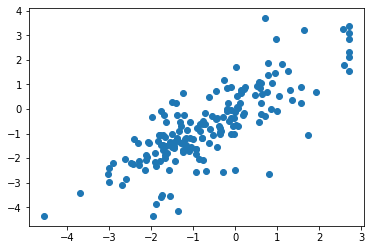

In [8]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [9]:
#SKLearn C parameter optimization

Cs = np.logspace(-6, -1, 10)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays, y_assays) 
c_param_full = clf_full.best_estimator_.C

In [10]:
c_param_full

0.007742636826811277

In [11]:
#Run regressor (trained on full dataset)

svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full))
svmReg_full.fit(X_assays, y_assays)
pred_values = svmReg_full.predict(X_test)

In [12]:
screening_data['pred_value'] = pred_values
screening_data.sort_values(by='pred_value').head(20)

,source,name,morgan_fingerprint,pred_value
9593,drugbank,Cefozopran,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.763881
16909,broad,monensin,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.247101
16907,broad,monensin,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.247101
16908,broad,monensin,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.247101
9398,drugbank,Nicomorphine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.910760
19058,broad,salvianolic-acid-B,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.687031
7767,drugbank,Monensin,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.595724
10797,reframe,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",-4.573847
328,drugbank,Ceftazidime,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-4.435309
184,drugbank,Bleomycin,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",-4.301706


Text(0.5, 1.0, 'SVM Validation Data')

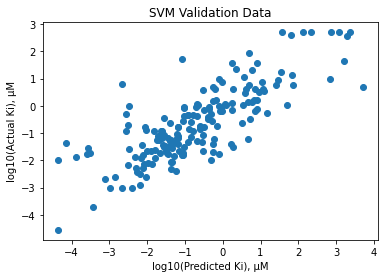

In [13]:
plt.scatter(pred, test_y)
plt.xlabel('log10(Predicted Ki), μM')
plt.ylabel('log10(Actual Ki), μM')
plt.title('SVM Validation Data')

(array([4.000e+00, 5.000e+00, 3.700e+01, 1.150e+02, 3.590e+02, 9.360e+02,
        2.313e+03, 4.388e+03, 4.869e+03, 3.835e+03, 2.357e+03, 1.026e+03,
        4.390e+02, 1.800e+02, 7.800e+01, 3.800e+01, 2.100e+01, 4.000e+00,
        6.000e+00, 1.000e+00]),
 array([-5.76388136, -5.05523942, -4.34659748, -3.63795554, -2.92931359,
        -2.22067165, -1.51202971, -0.80338777, -0.09474583,  0.61389611,
         1.32253806,  2.03118   ,  2.73982194,  3.44846388,  4.15710582,
         4.86574776,  5.5743897 ,  6.28303165,  6.99167359,  7.70031553,
         8.40895747]),
 <a list of 20 Patch objects>)

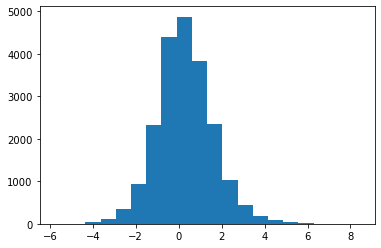

In [14]:
plt.hist(screening_data.pred_value, bins = 20)